#### William Nordhaus' DICE Model
The Dynamic Integrated Climate-Economy model, referred to as the DICE model or Dice model, is a computer-based integrated assessment model developed by 2018 Nobel Laureate William Nordhaus that “integrates in an end-to-end fashion the economics, carbon cycle, climate science, and impacts in a highly aggregated model that allows a weighing of the costs and benefits of taking steps to slow greenhouse warming." Nordhaus also developed the RICE model (Regional Integrated Climate-Economy model), a variant of the DICE model that was updated and developed alongside the DICE model. (source <a href="https://en.wikipedia.org/wiki/DICE_model">Wikipedia</a>).

This notebook is based on the GAMS code <a href="http://www.econ.yale.edu/~nordhaus/homepage/homepage/DICE2016R-091916ap.gms">`DICE2016R-091916ap.gms`</a> provided on  <a href="https://sites.google.com/site/williamdnordhaus/dice-rice" target=blank>Nordhaus' web page</a>.

In [1]:
%load_ext gams_magic

In [2]:
%%gams

# This is the beta version of DICE-2016R. The major changes are outlined in Nordhaus,
# Revisiting the social cost of carbon: Estimates from the DICE-2016R model,"
# September 30, 2016," available from the author.

# Version is DICE-2016R-091916ap.gms

# DICE-2016R September 2016 (adapted from DICE-2016R-091216a.gms)


Set  t  'Time periods (5 years per period)'  / 1*100 / ;

Parameters
## Availability of fossil fuels
    fosslim   'Maximum cumulative extraction fossil fuels (GtC)'         / 6000 /
## Time Step
    tstep     'Years per Period'                                         / 5 /
## If optimal control
    ifopt     'Indicator where optimized is 1 and base is 0'             / 0 /
## Preferences
    elasmu    'Elasticity of marginal utility of consumption'            / 1.45 /
    prstp     'Initial rate of social time preference per year'          / .015 /
## Population and technology
    gama      'Capital elasticity in production function'                / .300 /
    pop0      'Initial world population 2015 (millions)'                 / 7403 /
    popadj    'Growth rate to calibrate to 2050 pop projection'          / 0.134 /
    popasym   'Asymptotic population (millions)'                         / 11500 /
    dk        'Depreciation rate on capital (per year)'                  / .100 /
    q0        'Initial world gross output 2015 (trill 2010 USD)'         / 105.5 /
    k0        'Initial capital value 2015 (trill 2010 USD)'              / 223 /
    a0        'Initial level of total factor productivity'               / 5.115 /
    ga0       'Initial growth rate for TFP per 5 years'                  / 0.076 /
    dela      'Decline rate of TFP per 5 years'                          / 0.005 /
## Emissions parameters
    gsigma1   'Initial growth of sigma (per year)'                       / -0.0152 /
    dsig      'Decline rate of decarbonization (per period)'             / -0.001 /
    eland0    'Carbon emissions from land 2015 (GtCO2 per year)'         / 2.6 /
    deland    'Decline rate of land emissions (per period)'              / .115 /
    e0        'Industrial emissions 2015 (GtCO2 per year)'               / 35.85 /
    miu0      'Initial emissions control rate for base case 2015'        / .03 /
## Carbon cycle
# Initial Conditions
    mat0      'Initial Concentration in atmosphere 2015 (GtC)'           / 851 /
    mu0       'Initial Concentration in upper strata 2015 (GtC)'         / 460 /
    ml0       'Initial Concentration in lower strata 2015 (GtC)'         / 1740 /
    mateq     'Equilibrium concentration atmosphere (GtC)'               / 588 /
    mueq      'Equilibrium concentration in upper strata (GtC)'          / 360 /
    mleq      'Equilibrium concentration in lower strata (GtC)'          / 1720 /
# Flow paramaters
    b12       'Carbon cycle transition matrix'                           / .12 /
    b23       'Carbon cycle transition matrix'                           / 0.007 /
# These are for declaration and are defined later
    b11       'Carbon cycle transition matrix'
    b21       'Carbon cycle transition matrix'
    b22       'Carbon cycle transition matrix'
    b32       'Carbon cycle transition matrix'
    b33       'Carbon cycle transition matrix'
    sig0      'Carbon intensity 2010 (kgCO2 per output 2005 USD 2010)'
## Climate model parameters
    t2xco2    'Equilibrium temp impact (oC per doubling CO2)'            / 3.1 /
    fex0      '2015 forcings of non-CO2 GHG (Wm-2)'                      / 0.5 /
    fex1      '2100 forcings of non-CO2 GHG (Wm-2)'                      / 1.0 /
    tocean0   'Initial lower stratum temp change (C from 1900)'          / .0068 /
    tatm0     'Initial atmospheric temp change (C from 1900)'            / 0.85 /
    c1        'Climate equation coefficient for upper level'             / 0.1005 /
    c3        'Transfer coefficient upper to lower stratum'              / 0.088 /
    c4        'Transfer coefficient for lower level'                     / 0.025 /
    fco22x    'Forcings of equilibrium CO2 doubling (Wm-2)'              / 3.6813 /
## Climate damage parameters
    a10       'Initial damage intercept'                                 / 0 /
    a20       'Initial damage quadratic term'
    a1        'Damage intercept'                                         / 0 /
    a2        'Damage quadratic term'                                    / 0.00236 /
    a3        'Damage exponent'                                          / 2.00 /
## Abatement cost
    expcost2  'Exponent of control cost function'                        / 2.6 /
    pback     'Cost of backstop 2010$ per tCO2 2015'                     / 550 /
    gback     'Initial cost decline backstop cost per period'            / .025 /
    limmiu    'Upper limit on control rate after 2150'                   / 1.2 /
    tnopol    'Period before which no emissions controls base'           / 45 /
    cprice0   'Initial base carbon price (2010$ per tCO2)'               / 2 /
    gcprice   'Growth rate of base carbon price per year'                / .02 /

## Scaling and inessential parameters
# Note that these are unnecessary for the calculations
# They ensure that MU of first period's consumption =1 and PV cons = PV utilty
    scale1    'Multiplicative scaling coefficient'               / 0.0302455265681763 /
    scale2    'Additive scaling coefficient'                     / -10993.704 /
;

# Program control variables
Sets  tfirst(t), tlast(t), tearly(t), tlate(t) ;

Parameters
    l(t)          'Level of population and labor'
    al(t)         'Level of total factor productivity'
    sigma(t)      'CO2-equivalent-emissions output ratio'
    rr(t)         'Average utility social discount rate'
    ga(t)         'Growth rate of productivity from'
    forcoth(t)    'Exogenous forcing for other greenhouse gases'
    gl(t)         'Growth rate of labor'
    gcost1        'Growth of cost factor'
    gsig(t)       'Change in sigma (cumulative improvement of energy efficiency)'
    etree(t)      'Emissions from deforestation'
    cumetree(t)   'Cumulative from land'
    cost1(t)      'Adjusted cost for backstop'
    lam           'Climate model parameter'
    gfacpop(t)    'Growth factor population'
    pbacktime(t)  'Backstop price'
    optlrsav      'Optimal long-run savings rate used for transversality'
    scc(t)        'Social cost of carbon'
    cpricebase(t) 'Carbon price in base case'
    photel(t)     'Carbon Price under no damages (Hotelling rent condition)'
    ppm(t)        'Atmospheric concentrations parts per million'
    atfrac(t)     'Atmospheric share since 1850'
    atfrac2010(t) 'Atmospheric share since 2010'
;

# Program control definitions
tfirst(t) = yes$(t.val eq 1);
tlast(t)  = yes$(t.val eq card(t));
# Parameters for long-run consistency of carbon cycle
b11 = 1 - b12;
b21 = b12*MATEQ/MUEQ;
b22 = 1 - b21 - b23;
b32 = b23*mueq/mleq;
b33 = 1 - b32;
# Further definitions of parameters
a20 = a2;
sig0 = e0/(q0*(1-miu0));
lam = fco22x/ t2xco2;
l("1") = pop0;
loop(t, l(t+1)=l(t););
loop(t, l(t+1)=l(t)*(popasym/L(t))**popadj ;);

ga(t) = ga0*exp(-dela*5*((t.val-1)));
al("1") = a0;          loop(t, al(t+1)=al(t)/((1-ga(t))););
gsig("1") = gsigma1;   loop(t,gsig(t+1)=gsig(t)*((1+dsig)**tstep) ;);
sigma("1") = sig0;     loop(t,sigma(t+1)=(sigma(t)*exp(gsig(t)*tstep)););

pbacktime(t) = pback*(1-gback)**(t.val-1);
cost1(t) = pbacktime(t)*sigma(t)/expcost2/1000;

etree(t) = eland0*(1-deland)**(t.val-1);
cumetree("1") = 100;    loop(t,cumetree(t+1)=cumetree(t)+etree(t)*(5/3.666););

rr(t) = 1/((1+prstp)**(tstep*(t.val-1)));
forcoth(t) = fex0+ (1/17)*(fex1-fex0)*(t.val-1)$(t.val lt 18) + (fex1-fex0)$(t.val ge 18);
optlrsav = (dk + .004)/(dk + .004*elasmu + prstp)*gama;

# Base Case Carbon Price
cpricebase(t) = cprice0*(1+gcprice)**(5*(t.val-1));


Variables
    MIU(t)           'Emission control rate GHGs'
    FORC(t)          'Increase in radiative forcing (watts per m2 from 1900)'
    TATM(t)          'Increase temperature of atmosphere (degrees C from 1900)'
    TOCEAN(t)        'Increase temperatureof lower oceans (degrees C from 1900)'
    MAT(t)           'Carbon concentration increase in atmosphere (GtC from 1750)'
    MU(t)            'Carbon concentration increase in shallow oceans (GtC from 1750)'
    ML(t)            'Carbon concentration increase in lower oceans (GtC from 1750)'
    E(t)             'Total CO2 emissions (GtCO2 per year)'
    EIND(t)          'Industrial emissions (GtCO2 per year)'
    C(t)             'Consumption (trillions 2005 US dollars per year)'
    K(t)             'Capital stock (trillions 2005 US dollars)'
    CPC(t)           'Per capital consumption (thousands 2005 USD per year)'
    I(t)             'Investment (trillions 2005 USD per year)'
    S(t)             'Gross savings rate as fraction of gross world product'
    RI(t)            'Real interest rate (per annum)'
    Y(t)             'Gross world product net of abatement and damages (trillions 2005 USD per year)'
    YGROSS(t)        'Gross world product GROSS of abatement and damages (trillions 2005 USD per year)'
    YNET(t)          'Output net of damages equation (trillions 2005 USD per year)'
    DAMAGES(t)       'Damages (trillions 2005 USD per year)'
    DAMFRAC(t)       'Damages as fraction of gross output'
    ABATECOST(t)     'Cost of emissions reductions  (trillions 2005 USD per year)'
    MCABATE(t)       'Marginal cost of abatement (2005$ per ton CO2)'
    CCA(t)           'Cumulative industrial carbon emissions (GTC)'
    CCATOT(t)        'Total carbon emissions (GtC)'
    PERIODU(t)       'One period utility function'
    CPRICE(t)        'Carbon price (2005$ per ton of CO2)'
    CEMUTOTPER(t)    'Period utility'
    UTILITY          'Welfare function'
;

NonNegative Variables  MIU, TATM, MAT, MU, ML, Y, YGROSS, C, K, I ;


Equations
# Emissions and Damages
    EEQ(t)           'Emissions equation'
    EINDEQ(t)        'Industrial emissions'
    CCACCA(t)        'Cumulative industrial carbon emissions'
    CCATOTEQ(t)      'Cumulative total carbon emissions'
    FORCE(t)         'Radiative forcing equation'
    DAMFRACEQ(t)     'Equation for damage fraction'
    DAMEQ(t)         'Damage equation'
    ABATEEQ(t)       'Cost of emissions reductions equation'
    MCABATEEQ(t)     'Equation for MC abatement'
    CARBPRICEEQ(t)   'Carbon price equation from abatement'

# Climate and carbon cycle
    MMAT(t)          'Atmospheric concentration equation'
    MMU(t)           'Shallow ocean concentration'
    MML(t)           'Lower ocean concentration'
    TATMEQ(t)        'Temperature-climate equation for atmosphere'
    TOCEANEQ(t)      'Temperature-climate equation for lower oceans'

# Economic variables
    YGROSSEQ(t)      'Output gross equation'
    YNETEQ(t)        'Output net of damages equation'
    YY(t)            'Output net equation'
    CC(t)            'Consumption equation'
    CPCE(t)          'Per capita consumption definition'
    SEQ(t)           'Savings rate equation'
    KK(t)            'Capital balance equation'
    RIEQ(t)          'Interest rate equation'

# Utility
    CEMUTOTPEREQ(t)  'Period utility'
    PERIODUEQ(t)     'Instantaneous utility function equation'
    UTIL             'Objective function'
;

## Equations of the model
# Emissions and Damages
eeq(t)..             E(t)          =E= EIND(t) + etree(t);
eindeq(t)..          EIND(t)       =E= sigma(t) * YGROSS(t) * (1-(MIU(t)));
ccacca(t+1)..        CCA(t+1)      =E= CCA(t) + EIND(t)*5/3.666;
ccatoteq(t)..        CCATOT(t)     =E= CCA(t) + cumetree(t);
force(t)..           FORC(t)       =E= fco22x * ((log((MAT(t)/588.000))/log(2))) + forcoth(t);
damfraceq(t) ..      DAMFRAC(t)    =E= (a1*TATM(t)) + (a2*TATM(t)**a3) ;
dameq(t)..           DAMAGES(t)    =E= YGROSS(t) * DAMFRAC(t);
abateeq(t)..         ABATECOST(t)  =E= YGROSS(t) * cost1(t) * (MIU(t)**expcost2);
mcabateeq(t)..       MCABATE(t)    =E= pbacktime(t) * MIU(t)**(expcost2-1);
carbpriceeq(t)..     CPRICE(t)     =E= pbacktime(t) * (MIU(t))**(expcost2-1);

# Climate and carbon cycle
mmat(t+1)..          MAT(t+1)      =E= MAT(t)*b11 + MU(t)*b21 + (E(t)*(5/3.666));
mml(t+1)..           ML(t+1)       =E= ML(t) *b33  + MU(t)*b23;
mmu(t+1)..           MU(t+1)       =E= MAT(t)*b12 + MU(t)*b22 + ML(t)*b32;
tatmeq(t+1)..        TATM(t+1)     =E= TATM(t) + c1*((FORC(t+1)-(fco22x/t2xco2)*TATM(t))-(c3*(TATM(t)-TOCEAN(t))));
toceaneq(t+1)..      TOCEAN(t+1)   =E= TOCEAN(t) + c4*(TATM(t)-TOCEAN(t));

# Economic variables
ygrosseq(t)..        YGROSS(t)     =E= (al(t)*(L(t)/1000)**(1-GAMA))*(K(t)**GAMA);
yneteq(t)..          YNET(t)       =E= YGROSS(t)*(1-damfrac(t));
yy(t)..              Y(t)          =E= YNET(t) - ABATECOST(t);
cc(t)..              C(t)          =E= Y(t) - I(t);
cpce(t)..            CPC(t)        =E= 1000 * C(t) / L(t);
seq(t)..             I(t)          =E= S(t) * Y(t);
kk(t+1)..            K(t+1)        =L= (1-dk)**tstep * K(t) + tstep * I(t);
rieq(t+1)..          RI(t)         =E= (1+prstp) * (CPC(t+1)/CPC(t))**(elasmu/tstep) - 1;

# Utility
cemutotpereq(t)..    CEMUTOTPER(t) =E= PERIODU(t) * L(t) * rr(t);
periodueq(t)..       PERIODU(t)    =E= ((C(T)*1000/L(T))**(1-elasmu)-1)/(1-elasmu)-1;
util..               UTILITY       =E= tstep * scale1 * sum(t, CEMUTOTPER(t)) + scale2;


# Resource limit
CCA.up(t) = fosslim;

# Control rate limits
MIU.up(t)            = limmiu;
MIU.up(t)$(t.val<30) = 1;

##  Upper and lower bounds for stability
K.LO(t)      = 1;
MAT.LO(t)    = 10;
MU.LO(t)     = 100;
ML.LO(t)     = 1000;
C.LO(t)      = 2;
TOCEAN.UP(t) = 20;
TOCEAN.LO(t) = -1;
TATM.UP(t)   = 20;
CPC.LO(t)    = .01;
TATM.UP(t)   = 12;

# Control variables
set lag10(t);
lag10(t) = yes$(t.val gt card(t)-10);
S.FX(lag10(t)) = optlrsav;

# Initial conditions
CCA.FX(tfirst)    = 400;
K.FX(tfirst)      = k0;
MAT.FX(tfirst)    = mat0;
MU.FX(tfirst)     = mu0;
ML.FX(tfirst)     = ml0;
TATM.FX(tfirst)   = tatm0;
TOCEAN.FX(tfirst) = tocean0;


## Solution options
model CO2 / all /;

#### Optimized Run

In [3]:
%%gams
MIU.FX('1') = miu0; 
solve CO2 maximizing UTILITY using nlp;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),4517.3147,2493,2700,NLP,CONOPT,0.831


In [4]:
%gams_pull -d TATM RI EIND CPRICE
%gams_pull tstep t

In [5]:
import pandas as pd

def fillDF(orgDF,newDF,col):
    for j in zip(orgDF.level.index,orgDF.level):
        newDF.loc[2010+tstep[0]*j[0],col] = j[1]
    
df = {}
for d in ['TATM','RI','EIND','CPRICE']:
    df[d] = pd.DataFrame(columns=['opt','bas'])
    fillDF(eval(d),df[d],'opt')

#### Base Run

In [6]:
%%gams
# For base run, this subroutine calculates Hotelling rents
# Carbon price is maximum of Hotelling rent or baseline price
# The cprice equation is different from 2013R. Not sure what went wrong.
option bRatio = 1; MIU.LO('1') = 0; MIU.UP('1') = inf; # Reset fixing from opt run and discard basis
a2 = 0;
solve CO2 maximizing UTILITY using nlp;
photel(t) = CPRICE.L(t);
a2 = a20;
CPRICE.UP(t)$(t.val<tnopol+1) = max(photel(t),cpricebase(t));
option bRatio=0.25;
solve CO2 maximizing UTILITY using nlp;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),4620.3546,2493,2700,NLP,CONOPT,0.28
1,Normal (1),OptimalLocal (2),4485.7435,2493,2700,NLP,CONOPT,0.333


In [7]:
%gams_pull -d TATM RI EIND CPRICE

In [8]:
for d in ['TATM','RI','EIND','CPRICE']:
    fillDF(eval(d),df[d],'bas')

#### Visualization

<IPython.core.display.Javascript object>


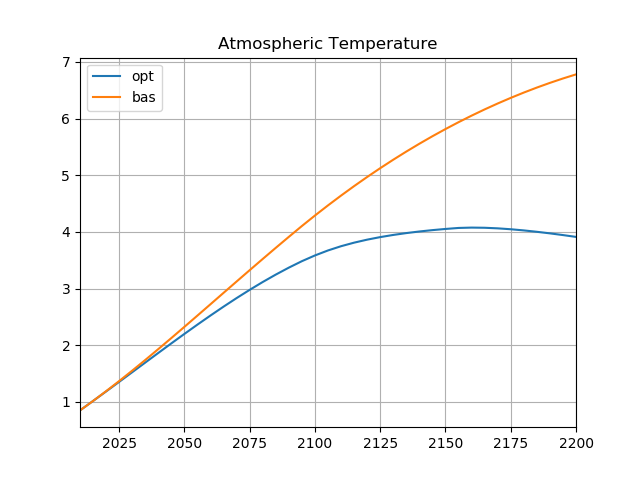

In [9]:
%matplotlib notebook
plot = df['TATM'].loc[2000:2200,:].plot(grid=True,title="Atmospheric Temperature")

<IPython.core.display.Javascript object>


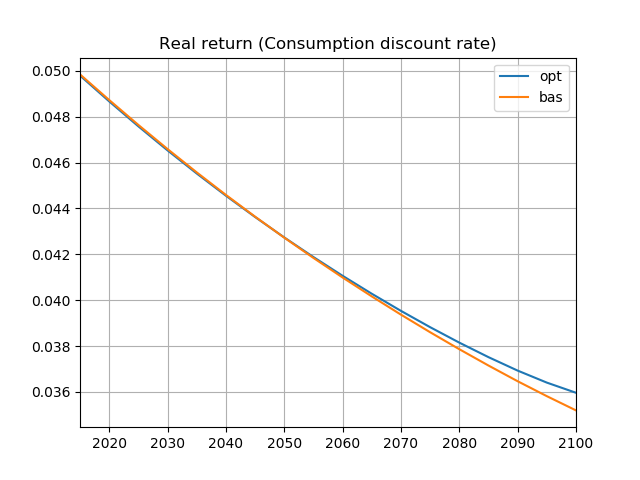

In [10]:
plot = df['RI'].loc[2015:2100,:].plot(grid=True,title="Real return (Consumption discount rate)")

<IPython.core.display.Javascript object>


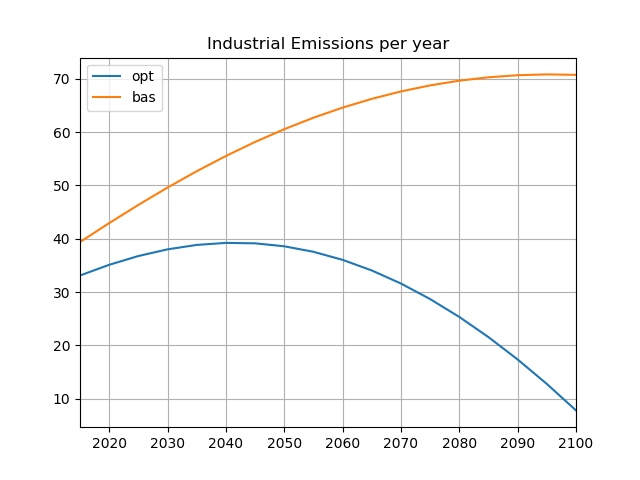

In [11]:
plot = df['EIND'].loc[2015:2100,:].plot(grid=True,title="Industrial Emissions per year")

<IPython.core.display.Javascript object>


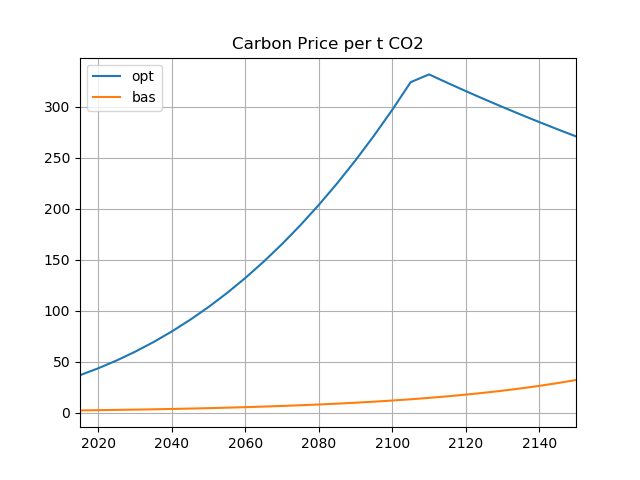

In [12]:
plot = df['CPRICE'].loc[2015:2150,:].plot(grid=True,title="Carbon Price per t CO2")

#### Post Processing

In [13]:
%%gams
## POST-SOLVE
# Calculate social cost of carbon and other variables
scc(t) = -1000*eeq.m(t)/(.00001+cc.m(t));
atfrac(t) = ((MAT.L(t)-588)/(CCATOT.L(t)+.000001  ));
atfrac2010(t) = ((MAT.L(t)-mat0)/(.00001+CCATOT.L(t)-CCATOT.L('1')  ));
ppm(t) = MAT.L(t)/2.13;

Parameter rep(*,t);
rep("Industrial Emissions GTCO2 per year", t) = EIND.L(t);
rep("Atmospheric concentration C (ppm)", t) = MAT.L(t)/2.13;
rep("Atmospheric Temperature", t) = TATM.L(t);
rep("Output Net Net)", t) = Y.L(t);
rep("Climate Damages fraction output", t) = DAMFRAC.L(t);
rep("Consumption Per Capita", t) = CPC.L(t);
rep("Carbon Price (per t CO2)", t) = CPRICE.L(t);
rep("Emissions Control Rate", t) = MIU.L(t);
rep("Social cost of carbon", t) = scc(t);
rep("Interest Rate", t) = RI.L(t);
rep("Population", t) = l(t);
rep("TFP", t) = al(t);
rep("Output gross,gross", t) = YGROSS.L(t);
rep("Change tfp", t) = ga(t);
rep("Capital", t) = K.L(t);
rep("s", t) = S.L(t);
rep("I", t) = I.L(t);
rep("Y gross net", t) = YNET.L(t);
rep("damages", t) = DAMAGES.L(t);
rep("damfrac", t) = DAMFRAC.L(t);
rep("abatement", t) = ABATECOST.L(t);
rep("sigma", t) = sigma(t);
rep("Forcings", t) = FORC.L(t);
rep("Other Forcings", t) = forcoth(t);
rep("Period utilty", t) = PERIODU.L(t);
rep("Consumption", t) = C.L(t);
rep("Land emissions", t) = etree(t);
rep("Cumulative ind emissions", t) = CCA.L(t);
rep("Cumulative total emissions", t) = CCATOT.L(t);
rep("Atmospheric concentrations Gt", t) = MAT.L(t);
rep("Atmospheric concentrations ppm", t) = ppm(t);
rep("Total Emissions GTCO2 per year", t) = E.L(t);
rep("Atmospheric concentrations upper", t) = MU.L(t);
rep("Atmospheric concentrations lower", t) = ML.L(t);
rep("Atmospheric fraction since 1850", t) = atfrac(t);
rep("Atmospheric fraction since 2010", t) = atfrac2010(t);


In [14]:
%gams_pull -d rep
def gt_pivot(df, index=None, columns=None, values=None):
    df = df.pivot(index=index, columns=columns, values=values)
    df.index.names = [None]
    df.columns.names = [None]
    return df

# Uncomment the next two lines to see the entire table
#pd.set_option('display.max_columns', None)  # or 1000
#pd.set_option('display.max_rows', None)  # or 1000

# Rename periods to years
rep['t'] = rep['t'].map({s:2010+(int(tstep[0])*int(s)) for s in t})
gt_pivot(rep,'t','*','value')

,Atmospheric Temperature,Atmospheric concentration C (ppm),Atmospheric concentrations Gt,Atmospheric concentrations lower,Atmospheric concentrations ppm,Atmospheric concentrations upper,Atmospheric fraction since 1850,Atmospheric fraction since 2010,Capital,Carbon Price (per t CO2),...,Population,Social cost of carbon,TFP,Total Emissions GTCO2 per year,Y gross net,abatement,damages,damfrac,s,sigma
2015,0.850000,399.530516,851.000000,1740.000000,399.530516,460.000000,0.526000,NaN,223.000000,2.000000,...,7403.000000,3.123105e+01,5.115000,38.344714,104.998084,0.000847,0.179338,0.001705,0.259555,0.350320
2020,1.016345,418.468429,891.337755,1740.670698,418.468429,471.289302,0.549229,0.771309,267.942171,2.208162,...,7853.090848,3.725411e+01,5.535714,41.684564,125.041570,0.001116,0.305569,0.002438,0.256250,0.324682
2025,1.189237,438.311198,933.602851,1741.419438,438.311198,485.128389,0.567352,0.756778,318.424941,2.437989,...,8264.920660,4.403940e+01,5.978891,44.967870,147.277995,0.001456,0.493217,0.003338,0.253388,0.301035
2030,1.367930,459.148661,977.986648,1742.263955,459.148661,501.231051,0.581651,0.744870,374.617056,2.691737,...,8638.974960,5.162013e+01,6.444808,48.151900,171.746414,0.001881,0.761815,0.004416,0.250919,0.279215
2035,1.551747,481.006178,1024.543158,1743.219953,481.006178,519.392164,0.593004,0.734869,436.677524,2.971895,...,8976.556918,6.002761e+01,6.933693,51.200920,198.479057,0.002410,1.134340,0.005683,0.248797,0.259074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490,6.723640,1024.288824,2181.735196,2300.805784,1024.288824,1323.740361,0.489584,0.482976,29087.209897,66.449417,...,11499.994128,3.145841e+02,88.662921,-2.359478,9557.482670,0.361817,1141.463085,0.106689,0.258278,0.001103
2495,6.713622,1021.672314,2176.162028,2306.701018,1021.672314,1320.200239,0.488355,0.481516,29517.683832,64.788182,...,11499.994915,2.009354e+02,89.294150,-2.276617,9671.481297,0.340383,1151.229273,0.106372,0.258278,0.001052
2500,6.703705,1019.097084,2170.676789,2312.562835,1019.097084,1316.718619,0.487134,0.480064,29919.118836,63.168477,...,11499.995596,1.067401e+02,89.914068,-2.196019,9781.606674,0.320124,1160.492837,0.106058,0.258278,0.001003
2505,6.693887,1016.562117,2165.277308,2318.391692,1016.562117,1313.294128,0.485920,0.478622,30298.403244,61.589265,...,11499.996186,3.770225e+01,90.522774,-2.117829,9888.546947,0.301007,1169.340467,0.105747,0.258278,0.000958
